<a href="https://colab.research.google.com/github/DinisMartinho/Retina-Blood-Vessel-Segmentation/blob/main/Colab%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install opendatasets --upgrade --quiet
import os, opendatasets, numpy, random, cv2, glob, time, tqdm, imageio, albumentations, torch, torchvision, matplotlib.pyplot

In [3]:
# GPU is necessary to run this notebook.
use_collab_gpu = True #@param {type:"boolean"}

In [4]:
if use_collab_gpu == True:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

In [ ]:
# We will use the Digital Retinal Images for Vessel Extraction dataset from Kaggle in order to train
# our Neural Network.
opendatasets.download("https://www.kaggle.com/datasets/zionfuo/drive2004")

In [6]:
# Let's seed our environment.
torch.manual_seed(32)
numpy.random.seed(32)
os.environ["PYTHONHASHSEED"] = str(32)
random.seed(32)
torch.cuda.manual_seed(32)
torch.backends.cudnn.deterministic = True

In [7]:
# Create a simple function that returns the paths for our training and testing data.
def load_data(data_path):
  train_x = sorted(glob.glob(os.path.join(data_path, "training", "images", "*.tif"))) #     Load the training images.
  train_y = sorted(glob.glob(os.path.join(data_path, "training", "1st_manual", "*.gif"))) # Load the training masks.

  test_x = sorted(glob.glob(os.path.join(data_path, "test", "images", "*.tif"))) #     Load the testing images.
  test_y = sorted(glob.glob(os.path.join(data_path, "test", "1st_manual", "*.gif"))) # Load the testing masks.

  return (train_x, train_y) , (test_x, test_y)

In [8]:
(train_x, train_y), (test_x , test_y) = load_data("./drive2004/DRIVE")

In [9]:
# Let's check the length of our datasets.
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

Train: 20 - 20
Test: 20 - 20


In [10]:
# Let's create a new folder to store our pre-processed data.
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

create_dir("./new_data/train/image/")
create_dir("./new_data/train/mask/")

create_dir("./new_data/test/image/")
create_dir("./new_data/test/mask/")

In [11]:
# Now let's augment our data.
def augment_data(images, masks, save_path, augment=True):
  image_size = (512, 512)

  for i, (x, y) in tqdm.tqdm(enumerate(zip(images, masks)), total=len(images)):
    # Extract the name from our images.
    name = x.split("/")[-1].split(".")[0]

    # Read the images and masks image data.
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = imageio.mimread(y)[0]

    # We will create 4 different variations for our
    # images and masks by simply flipping them horizontally
    # and vertically, as well as random rotating them.
    if augment == True:
      aug = albumentations.HorizontalFlip(p=1.0)
      augmented = aug(image=x, mask=y)
      x1 = augmented["image"]
      y1 = augmented["mask"]

      aug = albumentations.VerticalFlip(p=1.0)
      augmented = aug(image=x, mask=y)
      x2 = augmented["image"]
      y2 = augmented["mask"]

      aug = albumentations.Rotate(limit=45, p=1.0)
      augmented = aug(image=x, mask=y)
      x3 = augmented["image"]
      y3 = augmented["mask"]

      X = [x, x1, x2, x3]
      Y = [y, y1, y2, y3]

    else:
      X = [x]
      Y = [y]

    index = 0
    for I, M in zip(X, Y):
      I = cv2.resize(I, image_size)
      M = cv2.resize(M, image_size)

      tmp_image_name = f"{name}_{index}.png"
      tmp_mask_name = f"{name}_{index}.png"

      image_path = os.path.join(save_path, "image", tmp_image_name)
      mask_path = os.path.join(save_path, "mask", tmp_mask_name)

      cv2.imwrite(image_path, I)
      cv2.imwrite(mask_path, M)

      index +=1

In [12]:
augment_data(train_x, train_y, "./new_data/train/", augment=True) # Training Set
augment_data(test_x, test_y, "./new_data/test/", augment=False) # Testing Set

100%|██████████| 20/20 [00:00<00:00, 22.97it/s]


In [13]:
# Let's create our dataset and dataloader objects.
class Dataset(torch.utils.data.Dataset):
  def __init__(self, images_path, masks_path):
      self.images_path = images_path
      self.masks_path = masks_path
      self.n_samples = len(images_path)

  def __getitem__(self, index):
      image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
      image = image/255.0 ## (512, 512, 3)
      image = numpy.transpose(image, (2, 0, 1))  ## (3, 512, 512)
      image = image.astype(numpy.float32)
      image = torch.from_numpy(image)

      mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
      mask = mask/255.0   ## (512, 512)
      mask = numpy.expand_dims(mask, axis=0) ## (1, 512, 512)
      mask = mask.astype(numpy.float32)
      mask = torch.from_numpy(mask)

      return image, mask

  def __len__(self):
      return self.n_samples

In [14]:
train_x = sorted(glob.glob("./new_data/train/image/*"))
train_y = sorted(glob.glob("./new_data/train/mask/*"))

test_x = sorted(glob.glob("./new_data/test/image/*"))
test_y = sorted(glob.glob("./new_data/test/mask/*"))

In [15]:
#
train_dataset = Dataset(train_x, train_y)
test_dataset = Dataset(test_x, test_y)

In [16]:
#
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=6, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=6, shuffle=True, num_workers=2)

In [17]:
# Now let's create our Neural Network. (U-NET Architecture)

class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [18]:
class UNET(torch.nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = torch.nn.ModuleList()
        self.downs = torch.nn.ModuleList()
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                torch.nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = torch.nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = torchvision.transforms.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [19]:
# Let's create our custom loss function in order to train our neural network.

class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice


In [20]:
class DiceBCELoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = torch.nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [21]:
# Finally let's create our training function.

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
def train(model, loader, optimizer, loss_fn, device):
  epoch_loss = 0.0
  model.train()
  for x, y in loader:
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.float32)

      optimizer.zero_grad()
      y_pred = model(x)
      loss = loss_fn(y_pred, y)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

  epoch_loss = epoch_loss/len(loader)
  return epoch_loss

In [23]:
# Create evaluation function.

def evaluate(model, loader, loss_fn, device):
  epoch_loss = 0.0

  model.eval()
  with torch.no_grad():
      for x, y in loader:
          x = x.to(device, dtype=torch.float32)
          y = y.to(device, dtype=torch.float32)

          y_pred = model(x)
          loss = loss_fn(y_pred, y)
          epoch_loss += loss.item()

      epoch_loss = epoch_loss/len(loader)
  return epoch_loss

In [24]:
model = UNET(in_channels=3, out_channels=1).to(device)

In [55]:
# Finally we are ready to create the training loop.
num_epochs = 5

create_dir("./Checkpoints/")
checkpoint_path = "./Checkpoints/Pre-Trained RBVS Weights.pth"

In [56]:
lr = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

In [27]:
best_valid_loss = float("inf")

In [57]:
for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    test_loss = evaluate(model, test_loader, loss_fn, device)

    """ Saving the model """
    if test_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {test_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)

        best_valid_loss = test_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {test_loss:.3f}\n'
    print(data_str)

Epoch: 01 | Epoch Time: 0m 32s
	Train Loss: 0.273
	 Val. Loss: 0.423

Valid loss improved from 0.4160 to 0.4122. Saving checkpoint: ./Checkpoints/Pre-Trained RBVS Weights.pth
Epoch: 02 | Epoch Time: 0m 32s
	Train Loss: 0.256
	 Val. Loss: 0.412

Epoch: 03 | Epoch Time: 0m 32s
	Train Loss: 0.247
	 Val. Loss: 0.423

Valid loss improved from 0.4122 to 0.4049. Saving checkpoint: ./Checkpoints/Pre-Trained RBVS Weights.pth
Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 0.240
	 Val. Loss: 0.405

Epoch: 05 | Epoch Time: 0m 32s
	Train Loss: 0.237
	 Val. Loss: 0.406



In [ ]:
# Save our pre-trained weights to google drive.
from google.colab import drive
drive.mount('/content/gdrive')

In [59]:
!cp -r '/content/Checkpoints/Pre-Trained RBVS Weights.pth' /content/gdrive/MyDrive/Pre-Trained-Weights/

In [ ]:
# Here's an already pre-trained checkpoint,
!pip install -U --no-cache-dir gdown --pre

In [ ]:
!gdown --no-cookies 1-3cFvOyTzu55VTX6BwOQIrHRs5wt597c

In [43]:
model.load_state_dict(torch.load("./Pre-Trained RBVS Model.pth"))

<All keys matched successfully>

In [60]:
# Once our model is trained we can perform
# forward propagation.

def display_image(batch):
    batch = numpy.array(batch.detach().cpu())
    n = batch.shape[0]
    fig, axs = matplotlib.pyplot.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        axs[i].imshow(batch[i].transpose(1,2,0))
        axs[i].axis("off")
    matplotlib.pyplot.show()


def plot_batch_single_channel_images(batch):
    batch = numpy.array(batch.detach().cpu())
    n = batch.shape[0]
    fig, axs = matplotlib.pyplot.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        axs[i].imshow(batch[i][0], cmap='gray')
        axs[i].axis("off")
    matplotlib.pyplot.show()

Input images: 


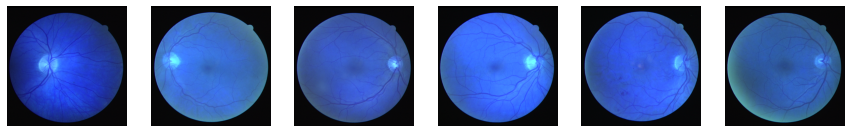

Output images: 


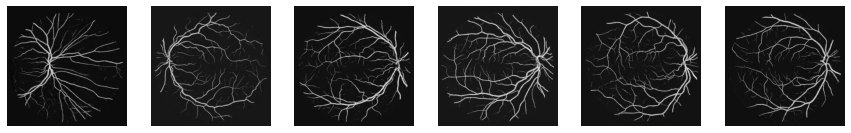

Input images: 


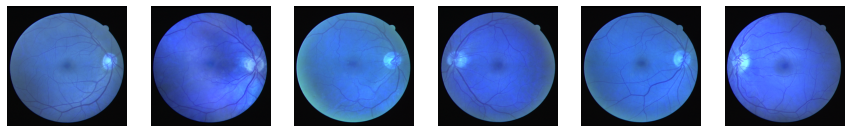

Output images: 


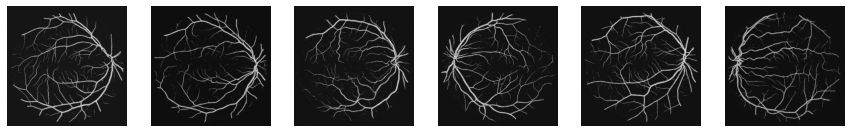

Input images: 


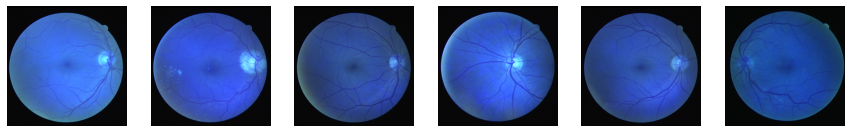

Output images: 


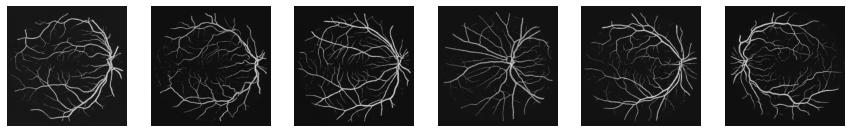

Input images: 


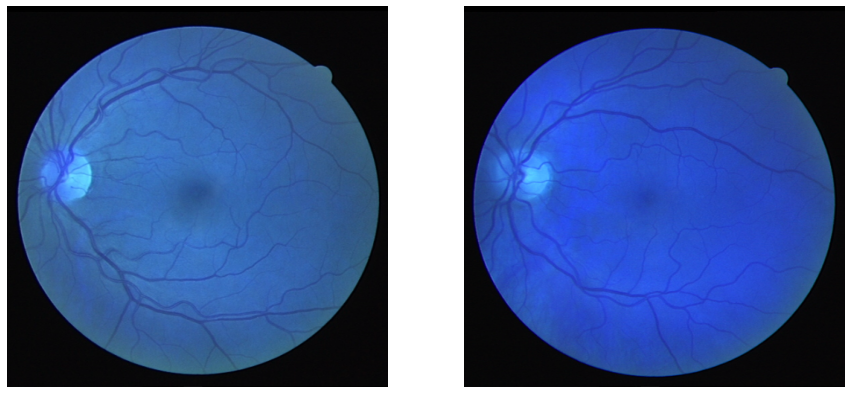

Output images: 


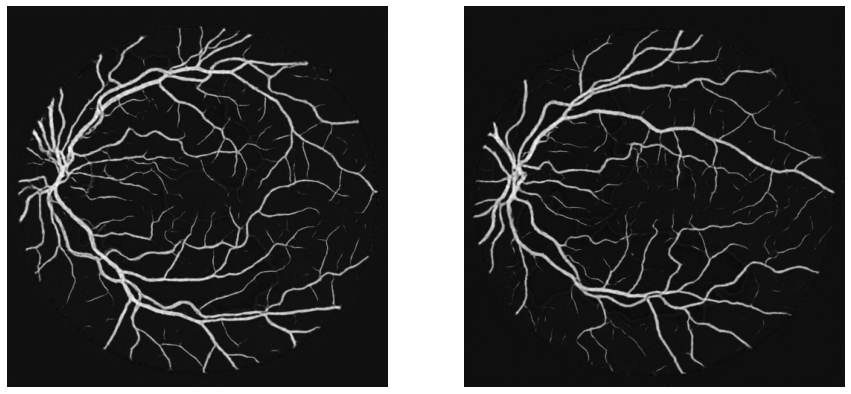

In [63]:
with torch.no_grad():
  for i, (x,y) in enumerate(test_loader):
    print("Input images: ")
    display_image(x)
    print("Output images: ")
    plot_batch_single_channel_images(model(x.to(device)))